In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import regularizers
from sklearn import datasets

import matplotlib.pyplot as plt
import numpy as np

import cv2

import time

from imageutils import block_dct
from imageutils import dataset_transform_block_dct

import random

Using TensorFlow backend.


In [2]:
def show_2d(im, figsize_x=3, cmap='Greys'):
    plt.figure(figsize=(figsize_x, figsize_x))
    plt.imshow(im, cmap=cmap)
    plt.show()

In [3]:
def show_flattened(im, figsize_x=3, cmap='Greys'):
    im = im.reshape(28,28)
    show_2d(im, figsize_x, cmap)

In [4]:
def diagnose(im):
    pred = model.predict(im, batch_size=1)
    print('Predicted {0}'.format(pred.argmax(axis=1)))
    show_flattened(im)

In [5]:
def stopwatch(value, fmt_string='{days}d:{hours}h:{minutes}m:{seconds}s'):
    '''From seconds to Days;Hours:Minutes;Seconds'''

    valueD = (((value/365)/24)/60)
    days = int (valueD)

    valueH = (valueD-days)*365
    hours = int(valueH)

    valueM = (valueH - hours)*24
    minutes = int(valueM)

    valueS = (valueM - minutes)*60
    seconds = int(valueS)
    data = {'days': days, 'hours': hours, 'minutes': minutes, 'seconds':seconds}


    print (fmt_string.format(**data))

In [6]:
print('[INFO] loading MNIST full dataset...')
dataset = datasets.fetch_mldata("MNIST Original")

[INFO] loading MNIST full dataset...


In [7]:
print(len(dataset))
print(dataset.data.shape)
print(dataset.data.__class__)

4
(70000, 784)
<class 'numpy.ndarray'>


In [8]:
# Reshape for CNN
data = dataset.data.astype("float").reshape(70000, 28, 28, 1) / 255.0
#data = 1.0-data
(trainX, testX, trainY, testY) = train_test_split(data, dataset.target, test_size=0.33)

(28, 28, 1)
(48, 48, 1)


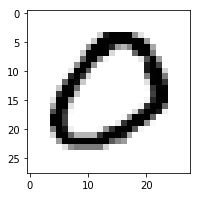

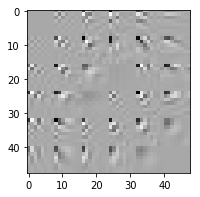

In [47]:
idx = random.randint(0,trainX.shape[0])

im = trainX[idx,:,:,:]
print(im.shape)

im_dct = block_dct(im)
print(im_dct.shape)

show_2d(im.reshape(28,28))
show_2d(im_dct.reshape((48,48)))


In [14]:
print(data.shape)
print(trainX.shape)
print(testX.shape)

(70000, 28, 28, 1)
(46900, 28, 28, 1)
(23100, 28, 28, 1)


In [15]:
trainX_dct = dataset_transform_block_dct(trainX, dct_size=8, stride=4)
testX_dct = dataset_transform_block_dct(testX, dct_size=8, stride=4)

In [16]:
print(trainX_dct.shape)
print(testX_dct.shape)

(46900, 48, 48, 1)
(23100, 48, 48, 1)


In [17]:
# Transform labels from int to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

print(trainY.shape)
print(testY.shape)

print(lb.classes_)
print(lb.classes_.shape)

(46900, 10)
(23100, 10)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
(10,)


In [33]:
# "Transform" CNN architecture with Keras
model = Sequential()
model.add(Conv2D(input_shape=(48,48,1), filters=32,  
                 use_bias=True, kernel_size=(5,5), strides=8))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(lb.classes_.shape[0], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
from kerasutils import describe_model

describe_model(model)

Layer 0: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 48, 48, 1)
    output=(None, 6, 6, 32)
    act=<function linear at 0x7f4b7e603c80>
    strides=(8, 8)
Layer 1: <class 'keras.layers.core.Activation'>
    input=(None, 6, 6, 32)
    output=(None, 6, 6, 32)
    act=<function relu at 0x7f4b7e603a60>
Layer 2: <class 'keras.layers.core.Dropout'>
    input=(None, 6, 6, 32)
    output=(None, 6, 6, 32)
    rate=0.1
Layer 3: <class 'keras.layers.core.Flatten'>
    input=(None, 6, 6, 32)
    output=(None, 1152)
Layer 4: <class 'keras.layers.core.Dense'>
    input=(None, 1152)
    output=(None, 256)
    act=<function linear at 0x7f4b7e603c80>
Layer 5: <class 'keras.layers.core.Activation'>
    input=(None, 256)
    output=(None, 256)
    act=<function relu at 0x7f4b7e603a60>
Layer 6: <class 'keras.layers.core.Dropout'>
    input=(None, 256)
    output=(None, 256)
    rate=0.2
Layer 7: <class 'keras.layers.core.Dense'>
    input=(None, 256)
    output=(None, 10)
    act=<functio

In [35]:
# Transform-based

start = time.time()
n_epochs = 10
batch_size = 128
H = model.fit(trainX_dct, trainY, validation_data=(testX_dct, testY), 
              epochs=n_epochs, batch_size=batch_size)
end = time.time()
print('Done!!!')
stopwatch(end-start)


Train on 46900 samples, validate on 23100 samples
Epoch 1/10
46900/46900 [==============================] - 3s 69us/step - loss: 0.3469 - acc: 0.9020 - val_loss: 0.1331 - val_acc: 0.9615
Epoch 2/10
46900/46900 [==============================] - 3s 62us/step - loss: 0.1150 - acc: 0.9653 - val_loss: 0.0791 - val_acc: 0.9766
Epoch 3/10
46900/46900 [==============================] - 3s 62us/step - loss: 0.0772 - acc: 0.9761 - val_loss: 0.0679 - val_acc: 0.9799
Epoch 4/10
46900/46900 [==============================] - 3s 62us/step - loss: 0.0599 - acc: 0.9816 - val_loss: 0.0571 - val_acc: 0.9826
Epoch 5/10
46900/46900 [==============================] - 3s 62us/step - loss: 0.0472 - acc: 0.9856 - val_loss: 0.0546 - val_acc: 0.9828
Epoch 6/10
46900/46900 [==============================] - 3s 62us/step - loss: 0.0396 - acc: 0.9874 - val_loss: 0.0484 - val_acc: 0.9853
Epoch 7/10
46900/46900 [==============================] - 3s 62us/step - loss: 0.0339 - acc: 0.9888 - val_loss: 0.0456 - val_acc

In [36]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(testX_dct, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(x) for x in lb.classes_]))

[INFO] Evaluating network...
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      2309
        1.0       0.99      0.99      0.99      2624
        2.0       0.97      1.00      0.99      2257
        3.0       0.99      0.98      0.98      2390
        4.0       0.99      0.98      0.99      2254
        5.0       0.99      0.99      0.99      2086
        6.0       0.99      0.99      0.99      2285
        7.0       0.99      0.99      0.99      2388
        8.0       0.98      0.98      0.98      2249
        9.0       0.98      0.98      0.98      2258

avg / total       0.99      0.99      0.99     23100



In [38]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
in_sample_classes = model.predict(trainX_dct, batch_size=batch_size)
print(classification_report(trainY.argmax(axis=1),
                            in_sample_classes.argmax(axis=1),
                            target_names=[str(x) for x in lb.classes_]))

[INFO] Evaluating network...
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4594
        1.0       1.00      1.00      1.00      5253
        2.0       1.00      1.00      1.00      4733
        3.0       1.00      1.00      1.00      4751
        4.0       1.00      1.00      1.00      4570
        5.0       1.00      1.00      1.00      4227
        6.0       1.00      1.00      1.00      4591
        7.0       1.00      1.00      1.00      4905
        8.0       1.00      1.00      1.00      4576
        9.0       0.99      1.00      1.00      4700

avg / total       1.00      1.00      1.00     46900



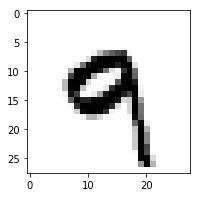

9.0


In [25]:
idx = random.randint(0, data.shape[0])
show_2d(data[idx,:,:].reshape((28,28)))
print(dataset.target[idx])


In [39]:
target_names=[str(x) for x in lb.classes_]
target_digits = testY.argmax(axis=1)
prediction_digits = predictions.argmax(axis=1)
misses = target_digits != prediction_digits
miss_indices = [index for index,val in enumerate(misses) if val == True]

print(target_digits.shape)
print(prediction_digits.shape)
print(len([val for val in misses if val == True]))
print(len(miss_indices))
print(miss_indices[0:30])



(23100,)
(23100,)
317
317
[90, 133, 171, 179, 229, 293, 320, 344, 423, 483, 577, 591, 612, 651, 764, 830, 914, 983, 1054, 1140, 1148, 1229, 1463, 1489, 1497, 1540, 1642, 1681, 1801, 1940]


(23100, 28, 28, 1)
19481
(28, 28, 1)
[0.    0.001 0.068 0.325 0.    0.345 0.    0.    0.239 0.022]
Target = 9.0, Prediction=5.0


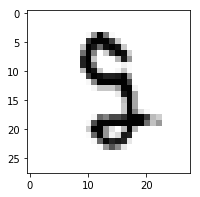

In [43]:
# Show examples of mis-classified digits from the test set
print(testX.shape)
idx = miss_indices[random.randint(0,len(miss_indices))]
im = testX[idx,:]
print(idx)
print(im.shape)
print(np.round(predictions[idx,:],3))
digit = testY[idx].argmax()
print('Target = {}, Prediction={}'.format(target_names[digit], target_names[prediction_digits[idx]]))
#diagnose(im)
show_flattened(im)

(23100, 28, 28, 1)
19881
(28, 28, 1)
Target = 6.0, Prediction=6.0


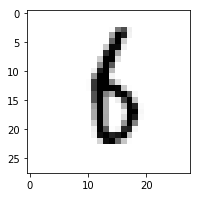

In [46]:
# Show random test digits with predict/target values.  
print(testX.shape)
idx = random.randint(0,testY.shape[0])
im = testX[idx,:]
print(idx)
print(im.shape)
digit = testY[idx].argmax()
print('Target = {}, Prediction={}'.format(target_names[digit], target_names[prediction_digits[idx]]))
#diagnose(im)
show_flattened(im)

In [143]:
plt.style.use('ggplot')
plt.figure()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>